In [59]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import re
import SimpleITK as sitk
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / (_range)
SAVE_PATH = r"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/smatunet_pixel"
ROOT = SAVE_PATH+"//test_best/images/"

all_files  = os.listdir(ROOT)
real_B_images = sorted([os.path.join(ROOT,file_name) for file_name in all_files if "real_B" in file_name])
real_A_images = sorted([os.path.join(ROOT,file_name) for file_name in all_files if "real_A" in file_name])
fake_B_images = sorted([os.path.join(ROOT,file_name) for file_name in all_files if "fake_B" in file_name])

for i in range(len(real_A_images)):
    real_A = np.array(Image.open(real_A_images[i]).convert("L"))/255.
    real_B = np.array(Image.open(real_B_images[i]).convert("L"))/255.
    fake_B = np.array(Image.open(fake_B_images[i]).convert("L"))/255.
    fake_B[fake_B<0.05] = real_B[fake_B<0.05] # 小数据量时暂时去除部分噪点
    fake_B[fake_B>0.95] = real_B[fake_B>0.95]
    file_name = real_B_images[i].split("/")[-1].split("real")[-2]
    fake_B_HU = fake_B*(1800+1000)-1000
    real_B_HU = real_B*(1800+1000)-1000
    error = (fake_B_HU - real_B_HU)
    os.makedirs(os.path.join(ROOT,"numpy"), exist_ok=True)
    np.save(os.path.join(ROOT,"numpy",file_name+"fake_B"),fake_B_HU)
    np.save(os.path.join(ROOT,"numpy",file_name+"real_A"),real_A)
    np.save(os.path.join(ROOT,"numpy",file_name+"real_B"),real_B_HU)
    np.save(os.path.join(ROOT,"numpy",file_name+"error"),error)

fake_B_list_all = [os.path.join(ROOT,"numpy",_file) for _file in sorted(os.listdir(os.path.join(ROOT,"numpy"))) if "fake_B" in _file]
real_B_list_all = [os.path.join(ROOT,"numpy",_file) for _file in sorted(os.listdir(os.path.join(ROOT,"numpy"))) if "real_B" in _file]
real_A_list_all = [os.path.join(ROOT,"numpy",_file) for _file in sorted(os.listdir(os.path.join(ROOT,"numpy"))) if "real_A" in _file]
error_list_all = [os.path.join(ROOT,"numpy",_file) for _file in sorted(os.listdir(os.path.join(ROOT,"numpy"))) if "error" in _file]

import os
os.getcwd()   #取得当前工作目录
os.chdir(SAVE_PATH)
#filename = "001_ct" # 001_ct 038_ct 052_ct
for filename in ["001_ct" ,"038_ct", "052_ct","007_ct"\
                ,"009_ct","010_ct","050_ct","051_ct"]:
    fake_B_list = [_file for _file in fake_B_list_all if filename in _file]
    real_B_list = [_file for _file in real_B_list_all if filename in _file]
    real_A_list = [_file for _file in real_A_list_all if filename in _file]
    print(len(real_A_list))
    error_list = [_file for _file in error_list_all if filename in _file]
    real_A_array = []
    for file in real_A_list:
        array_ = np.load(file)
        real_A_array.append(array_)
    real_A_array = np.array(real_A_array)
    real_A_array = np.transpose(real_A_array,(1,2,0))

    fake_B_array = []
    for file in fake_B_list:
        array_ = np.load(file)
        fake_B_array.append(array_)
    fake_B_array = np.array(fake_B_array)
    fake_B_array = np.transpose(fake_B_array,(1,2,0))

    real_B_array = []
    for file in real_B_list:
        array_ = np.load(file)
        real_B_array.append(array_)
    real_B_array = np.array(real_B_array)
    real_B_array = np.transpose(real_B_array,(1,2,0))

    real_A_out = sitk.GetImageFromArray(real_A_array)
    fake_B_out = sitk.GetImageFromArray(fake_B_array)
    real_B_out = sitk.GetImageFromArray(real_B_array)
    
    sitk.WriteImage(real_A_out,filename+"_real_A_out.nii")
    sitk.WriteImage(fake_B_out,filename+"_fake_B_out.nii")
    sitk.WriteImage(real_B_out,filename+"_real_B_out.nii")

187
145
180
22
22
26
21
23


In [104]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
from os import listdir
from os.path import splitext
import nibabel as nb
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from nibabel.viewers import OrthoSlicer3D
import scipy.io as io
import matplotlib.ticker as ticker
import os
os.getcwd()   #取得当前工作目录

net_lists = ["unet_basic","unet_pixel","cbamunet_basic","cbamunet_pixel"]#,"resnet_basic","resnet_pixel"]
for net in net_lists:
    SAVE_PATH = os.path.join(r"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/",net)
    print(net)
    os.chdir(SAVE_PATH)


    PLOT = False
    plot_range = [0,999]

    COLOR_BAR_FONT_SIZE = 6
    all_mae = 0
    nn = 0
    for MODE in ["sag","cor","axi"]:        # 三个视图
        for pat_num in ["038","052","007","010","050","051"]: # 三个病例 "001","009",
            n = 110 # 第几层，可修改
            fake_img = nib.load("./"+pat_num+"_ct_fake_B_out.nii")
            fake_ct_array = np.asanyarray(fake_img.dataobj)
            fake_ct_array = np.array(fake_ct_array)#[:90,:,:]

            real_img = nib.load("./"+pat_num+"_ct_real_B_out.nii")
            real_ct_array = np.asanyarray(real_img.dataobj)
            real_ct_array = np.array(real_ct_array)#[:90,:,:]

            assert fake_ct_array.shape == real_ct_array.shape
            a,b,c = fake_ct_array.shape

            # plt.colorbar(..., format=fmt)
            if PLOT:
                if MODE == "sag" or MODE == "cor":
                    ax_aspect = b/a
                else:
                    ax_aspect = 1

                func = lambda x,pos: "{:g}HU".format(x)
                fmt = ticker.FuncFormatter(func)
                plt.figure(dpi=400)

                a1 = plt.subplot(1,3,1)

                if MODE == "sag":
                    fake_array = fake_ct_array[:,:,n]
                    real_array = real_ct_array[:,:,n]
                elif MODE == "cor":
                    fake_array = fake_ct_array[:,n,:]
                    real_array = real_ct_array[:,n,:]
                else:
                    fake_array = fake_ct_array[n,:,:]
                    real_array = real_ct_array[n,:,:]

                im =plt.imshow(fake_array,cmap='gray')
                a1.set_aspect(ax_aspect)
                plt.axis('off')
                plt.rcParams['font.size'] = COLOR_BAR_FONT_SIZE
                #plt.colorbar()
                cb1 = plt.colorbar(im, fraction=0.03, pad=0.05, format=fmt)
                tick_locator = ticker.MaxNLocator(nbins=4)  # colorbar上的刻度值个数
                cb1.locator = tick_locator
                cb1.update_ticks()


                a2 = plt.subplot(1,3,2)
                im2 =plt.imshow(real_array,cmap='gray')
                a2.set_aspect(ax_aspect)
                plt.axis('off')
                plt.rcParams['font.size'] = COLOR_BAR_FONT_SIZE
                cb1 = plt.colorbar(im2, fraction=0.03, pad=0.05, format=fmt)
                tick_locator = ticker.MaxNLocator(nbins=4)  # colorbar上的刻度值个数
                cb1.locator = tick_locator
                cb1.update_ticks()


                a3 = plt.subplot(1,3,3)
                im3 =plt.imshow(fake_array-real_array,cmap='gray')
                a3.set_aspect(ax_aspect)
                plt.axis('off')
                plt.rcParams['font.size'] = COLOR_BAR_FONT_SIZE
                cb1 = plt.colorbar(im3, fraction=0.03, pad=0.05, format=fmt)
                tick_locator = ticker.MaxNLocator(nbins=4)  # colorbar上的刻度值个数
                cb1.locator = tick_locator
                cb1.update_ticks()
                plt.tight_layout()
                #plt.savefig("./"+pat_num+"_"+MODE+".jpg")
                plt.show()
            #print((fake_ct_array-real_ct_array).shape)
            mae= np.abs((fake_ct_array-real_ct_array))[plot_range[0]:plot_range[1],30:-30,30:-30].mean()
            #print(f"P:{pat_num}")
            #print(f"MAE : {mae}")
            #print(f"ME : {(fake_ct_array-real_ct_array)[plot_range[0]:plot_range[1],:].mean()}")
            all_mae += mae
            nn += 1
    print(f"Mean MAE:{all_mae/nn}")

unet_basic
Mean MAE:111.80967265442642
unet_pixel
Mean MAE:106.12484743187001
cbamunet_basic
Mean MAE:112.66359430364471
cbamunet_pixel
Mean MAE:106.15099789939023


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
from os import listdir
from os.path import splitext
import nibabel as nb
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from nibabel.viewers import OrthoSlicer3D
import scipy.io as io
import matplotlib.ticker as ticker
import os
os.getcwd()   #取得当前工作目录

SAVE_PATH = r"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/cbamunet_basic/"
os.chdir(SAVE_PATH)

PLOT = False
plot_range = [0,999]

COLOR_BAR_FONT_SIZE = 6
all_mae = 0
nn = 0
for MODE in ["sag","cor","axi"]:        # 三个视图
    for pat_num in ["001","038","052","007","009","010","050","051"]: # 三个病例
        n = 110 # 第几层，可修改
        fake_img = nib.load("./"+pat_num+"_ct_fake_B_out.nii")
        fake_ct_array = np.asanyarray(fake_img.dataobj)
        fake_ct_array = np.array(fake_ct_array)#[:90,:,:]

        real_img = nib.load("./"+pat_num+"_ct_real_B_out.nii")
        real_ct_array = np.asanyarray(real_img.dataobj)
        real_ct_array = np.array(real_ct_array)#[:90,:,:]

        assert fake_ct_array.shape == real_ct_array.shape
        a,b,c = fake_ct_array.shape

        # plt.colorbar(..., format=fmt)
        if PLOT:
            if MODE == "sag" or MODE == "cor":
                ax_aspect = b/a
            else:
                ax_aspect = 1

            func = lambda x,pos: "{:g}HU".format(x)
            fmt = ticker.FuncFormatter(func)
            plt.figure(dpi=400)

            a1 = plt.subplot(1,3,1)

            if MODE == "sag":
                fake_array = fake_ct_array[:,:,n]
                real_array = real_ct_array[:,:,n]
            elif MODE == "cor":
                fake_array = fake_ct_array[:,n,:]
                real_array = real_ct_array[:,n,:]
            else:
                fake_array = fake_ct_array[n,:,:]
                real_array = real_ct_array[n,:,:]

            im =plt.imshow(fake_array,cmap='gray')
            a1.set_aspect(ax_aspect)
            plt.axis('off')
            plt.rcParams['font.size'] = COLOR_BAR_FONT_SIZE
            #plt.colorbar()
            cb1 = plt.colorbar(im, fraction=0.03, pad=0.05, format=fmt)
            tick_locator = ticker.MaxNLocator(nbins=4)  # colorbar上的刻度值个数
            cb1.locator = tick_locator
            cb1.update_ticks()


            a2 = plt.subplot(1,3,2)
            im2 =plt.imshow(real_array,cmap='gray')
            a2.set_aspect(ax_aspect)
            plt.axis('off')
            plt.rcParams['font.size'] = COLOR_BAR_FONT_SIZE
            cb1 = plt.colorbar(im2, fraction=0.03, pad=0.05, format=fmt)
            tick_locator = ticker.MaxNLocator(nbins=4)  # colorbar上的刻度值个数
            cb1.locator = tick_locator
            cb1.update_ticks()


            a3 = plt.subplot(1,3,3)
            im3 =plt.imshow(fake_array-real_array,cmap='gray')
            a3.set_aspect(ax_aspect)
            plt.axis('off')
            plt.rcParams['font.size'] = COLOR_BAR_FONT_SIZE
            cb1 = plt.colorbar(im3, fraction=0.03, pad=0.05, format=fmt)
            tick_locator = ticker.MaxNLocator(nbins=4)  # colorbar上的刻度值个数
            cb1.locator = tick_locator
            cb1.update_ticks()
            plt.tight_layout()
            #plt.savefig("./"+pat_num+"_"+MODE+".jpg")
            plt.show()
        #print((fake_ct_array-real_ct_array).shape)
        mae= np.abs((fake_ct_array-real_ct_array))[plot_range[0]:plot_range[1],:,:].mean()
        print(f"P:{pat_num}")
        print(f"MAE : {mae}")
        #print(f"ME : {(fake_ct_array-real_ct_array)[plot_range[0]:plot_range[1],:].mean()}")
        all_mae += mae
        nn += 1
print(f"Mean ME:{all_mae/nn}")

P:001
MAE : 87.6304272074388
P:038
MAE : 72.15162866062377
P:052
MAE : 62.970755516833385
P:007
MAE : 45.437721075646195
P:009
MAE : 82.85721341981395
P:010
MAE : 80.33840173689666
P:050
MAE : 80.23172615400328
P:051
MAE : 67.29115049552432
P:001
MAE : 87.6304272074388
P:038
MAE : 72.15162866062377
P:052
MAE : 62.970755516833385
P:007
MAE : 45.437721075646195
P:009
MAE : 82.85721341981395
P:010
MAE : 80.33840173689666
P:050
MAE : 80.23172615400328
P:051
MAE : 67.29115049552432
P:001
MAE : 87.6304272074388
P:038
MAE : 72.15162866062377
P:052
MAE : 62.970755516833385
P:007
MAE : 45.437721075646195
P:009
MAE : 82.85721341981395
P:010
MAE : 80.33840173689666
P:050
MAE : 80.23172615400328
P:051
MAE : 67.29115049552432
Mean ME:72.36362803334755


# Plot Loss

In [63]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

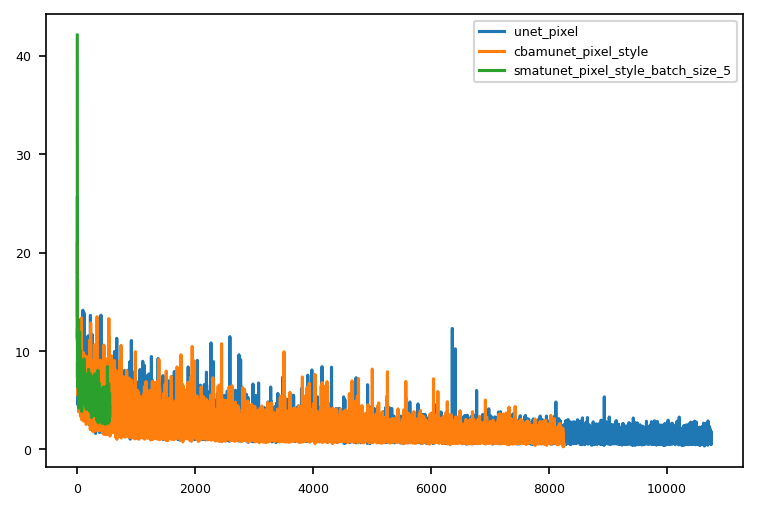

In [88]:
import os
os.getcwd()   #取得当前工作目录

SAVE_PATH = r"/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/"
os.chdir(SAVE_PATH)

name_list = ["unet_pixel","cbamunet_pixel_style","smatunet_pixel_style_batch_size_5"]

plt.figure(dpi=150)
for name in name_list:
    L1_loss = []
    file = os.path.join("./checkpoints/",name,"loss_log.txt")
    file = open(file)
    for line in file.readlines():
        # 剔除开头部分
        if "epoch" not in line :
            continue

        # 正则表达式分割
        b= re.split(r" +",line)
        if name == "smatunet_pixel_style_batch_size_5":
            L1_loss.append(float(b[-8]))
        else:
            L1_loss.append(float(b[-6]))

    plt.plot(L1_loss[:],label=name)
plt.legend()
plt.show()

In [66]:
!pwd

/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/smatunet_pixel
